In [424]:
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from IPython.display import clear_output

# SVM Training Functions

<a href="https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf">Guide to SVM Training</a>
### To-do:
<ul>
    <li> Make data generation process more efficient/less redundant </li>
    <li> Track accuracy report </li>
</ul>

In [12]:
subjects

['AT', 'CC', 'CG', 'GD', 'JM', 'JR', 'JS', 'NL', 'RK', 'SC', 'TP', 'YY']

In [444]:
'''
Gets a list of subject IDs and file suffix, given a path to the data files

Note: subject ID must be only 2 characters for this to work, and all data files
must have same suffix
'''
def get_subjects(path, removeML = False):
    
    files = os.listdir(path)
    subjects = [f[:2] for f in files]
    suffix = files[0][2:]
    
    if removeML:
        subjects.remove('ML')
        
    subjects.sort()
    
    return subjects, suffix

In [58]:
'''
Randomly selects half of the labels in the data to switch to the other class. 

y_data:   list of the label data
classes:  list of the two different classes of labels
'''
def scramble_labels(y_data, classes):
    
    for index in np.nditer(np.random.choice(len(y_data), size=len(y_data)//2, replace=False)):
        
        if y_data[index] == classes[0]:
            y_data[index] = classes[1]
        else:
            y_data[index] = classes[0]


In [357]:
'''
Gets individual subject data.

path:          directory to data files
subject:       specific subject data to load
suffix:        ending to filename
roi:           0 for MT data, 1 for V1 data
conds:         which conditional dataset to extract
block_length:  standardized number of voxels per block
'''
def extract_subject_data(path, subject, suffix, roi, conds, block_length):
    
    x_data = []
    y_data = []
    
    path_to_file = path + subject + suffix
    mat = scipy.io.loadmat(path_to_file)['roi_scanData'][0][roi]
        
    for scan in range(len(mat[0])):
            
        for cond in conds:
            
            for block in range(len(mat[0][scan][0][cond][0])):

                block_data = []
                for tr in range(len(mat[0][scan][0][cond][0][block][0])):
                    
                    # Extract all voxel data from individual TRs
                    block_data.extend(mat[0][scan][0][cond][0][block][0][tr][0][0][0].tolist())
                
                # Filters for most active voxels in each block
                block_data.sort()
                block_data = block_data[-block_length:]
                
                x_data.append(block_data)
                y_data.append(mat[0][scan][1][cond][0])
                
    data = {'x': x_data, 'y': y_data}
    return data

In [241]:
'''
Generates training and testing data.
'''
def generate_data(subjects, inner_test_subject, outer_test_subject, path, suffix, block_length, roi, conds):
    
    data = []
    
    x_train = []
    y_train = []
    
    x_test_inner = []
    y_test_inner = []
    
    x_test_outer = []
    y_test_outer = []
    
    for subject in range(len(subjects)):
        
        subject_data = extract_subject_data(path, subjects[subject], suffix, roi, conds, block_length)
        if subject == outer_test_subject:
            x_test_outer.extend(subject_data['x'])
            y_test_outer.extend(subject_data['y'])
        elif subject == inner_test_subject:
            x_test_inner.extend(subject_data['x'])
            y_test_inner.extend(subject_data['y'])
        else:
            x_train.extend(subject_data['x'])
            y_train.extend(subject_data['y'])
    
    x_train_len = len(x_train)
    x_test_outer_len = len(x_test_outer)
    
    data.extend(x_train)
    data.extend(x_test_outer)
    data.extend(x_test_inner)
    
    # MinMaxScaler scales each feature to values between 0 and 1 among all x data
    scaler = MinMaxScaler(feature_range=(0, 1))
    x_normalized = scaler.fit_transform(data)
    x_train, x_test_outer, x_test_inner = x_normalized[:x_train_len], x_normalized[x_train_len:x_train_len+x_test_outer_len], x_normalized[x_train_len+x_test_outer_len:]

    y_train = np.stack(y_train, axis=0)
    
    return x_train, y_train, x_test_inner, y_test_inner, x_test_outer, y_test_outer

In [452]:
def get_optimal_run(x_train, y_train, x_test, y_test, kernels, gamma_range, C_range):
    
    gamma_vals = np.logspace(gamma_range['start'], gamma_range['stop'], gamma_range['num'], base=gamma_range['base'])
    C_vals = np.logspace(C_range['start'], C_range['stop'], C_range['num'], base=C_range['base'])

    param_grid = ParameterGrid({'kernel': kernels, 'gamma': gamma_vals, 'C': C_vals})
    
    best_acc = 0
    best_params = None
    for params in list(param_grid):
        
        svclassifier = SVC(kernel=params['kernel'], gamma=params['gamma'], C=params['C'], max_iter=-1)
        svclassifier.fit(x_train, y_train)
        
        curr_acc = svclassifier.score(x_test, y_test)
        
        if curr_acc > best_acc:
            best_acc = curr_acc
            best_params = params
            
    return best_params, best_acc


In [450]:
'''
Trains and tests the classifier.

path:          path to data files
roi:           which area of brain imaging to check (0 for V1, 1 for MT)
conds:         which conditional datasets to classify (trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3)
block_length:  standardized number of voxels per block
kernels:       list of kernels to search grid on
gamma_range:   dictionary of start, stop, num, and base values to generate gamma values to search grid for
C_range:       dictionary of start, stop, num, and base values to generate C values to search grid for
scramble:      boolean value specifying whether training labels should be scrambled
'''
def train(path, roi, conds, block_length, kernels, gamma_range, C_range, scramble=False):
    
    subjects, suffix = get_subjects(path)
    
    inner_acc_report = pd.DataFrame(index=subjects, columns=subjects)
    outer_acc_report = pd.DataFrame(index=subjects, columns=subjects)
    
    for outer_subject in range(len(subjects)):
        
        print("Currently on outer subject #%i." % (outer_subject+1))

        dummy_subject = 0
        if outer_subject == 0:
            dummy_subject = 1
        _, _, _, _, x_test_outer, y_test_outer = generate_data(subjects, dummy_subject, outer_subject, path, suffix, block_length, roi, conds)
        
        start_time = time.time()
        
        for inner_subject in range(len(subjects)):

            if inner_subject == outer_subject:
                continue

            print("Currently on inner subject #%i." % (inner_subject+1))    
            x_train, y_train, x_test, y_test, _, _ = generate_data(subjects, inner_subject, outer_subject, path, suffix, block_length, roi, conds)
            
            if scramble:
                scramble_labels(y_train, classes)
                
            # gets optimal params for training dataset from grid search
            params, inner_acc = get_optimal_run(x_train, y_train, x_test, y_test, kernels, gamma_range, C_range) 
            print('Found best params for current inner subject.')
            
            # train model using optimal params for this set
            svclassifier = SVC(kernel=params['kernel'], gamma=params['gamma'], C=params['C'], max_iter=-1)
            svclassifier.fit(x_train, y_train)
            
            print('Testing outer subject...')
            outer_acc = svclassifier.score(x_test_outer, y_test_outer)
            
            # logs inner and outer subject accuracy data in dataframe
            index = subjects[outer_subject]
            col = subjects[inner_subject]
            
            inner_acc_report.at[index, col] = inner_acc
            outer_acc_report.at[index, col] = outer_acc

        clear_output()
        
        end_time = time.time()
        exec_time = end_time - start_time
        minutes = exec_time // 60
        seconds = exec_time % 60
        print('Last turn took %i minutes and %f seconds.' % (minutes, seconds))
    
    clear_output()
    return inner_acc_report, outer_acc_report

# Training model for accuracy

For rbf kernel, should check grid points to find good values of C and gamma (necessary for performance) <br>
<a href="https://scikit-learn.org/stable/modules/svm.html#parameters-of-the-rbf-kernel"> sklearn.model_selection.GridSearchCV </a><br>

## Unscrambled Labels

### 5 Folds w/ ML

In [453]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624
folds = 5

gamma_range = {'start': -13, 'stop': 1, 'num': 8, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 8, 'base': 2.0}

inner_accs, outer_accs = train(path, roi, conds, block_length, gamma_range, C_range, folds)

Text(0.5, 69.0, 'Inner Subject')

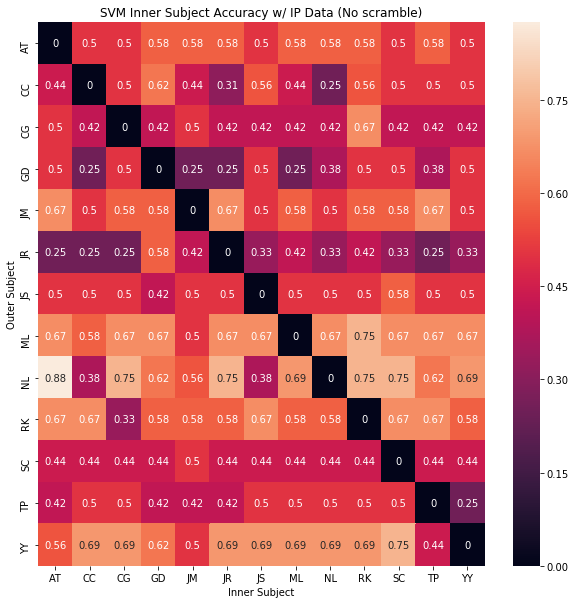

In [456]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(outer_accs.fillna(value=0), annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('SVM Inner Subject Accuracy w/ IP Data (No scramble)')
ax.set_ylabel('Outer Subject')
ax.set_xlabel('Inner Subject')

### 5 Folds

In [399]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624
folds = 5

gamma_range = {'start': -13, 'stop': 1, 'num': 8, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 8, 'base': 2.0}

accs_unscrambled, outer_accs_unscrambled = train(path, roi, conds, block_length, gamma_range, C_range, folds)
# accs_unscrambled.to_csv('no_scramble.csv', sep='\t')

(array([10., 26., 26., 38., 18.,  4.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  6.]),
 array([0.48484848, 0.51060606, 0.53636364, 0.56212121, 0.58787879,
        0.61363636, 0.63939394, 0.66515152, 0.69090909, 0.71666667,
        0.74242424, 0.76818182, 0.79393939, 0.81969697, 0.84545455,
        0.87121212, 0.8969697 , 0.92272727, 0.94848485, 0.97424242,
        1.        ]),
 <a list of 20 Patch objects>)

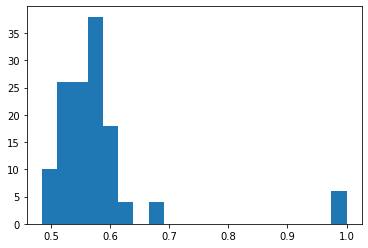

In [412]:
accs_unscrambled = pd.read_csv('output/no_scramble5.csv', sep='\t', index_col=0)
vals = []
for column in accs_unscrambled:
    vals.extend(accs_unscrambled[column].tolist())
vals = [x for x in vals if str(x) != 'nan']

plt.hist(vals, bins=20)

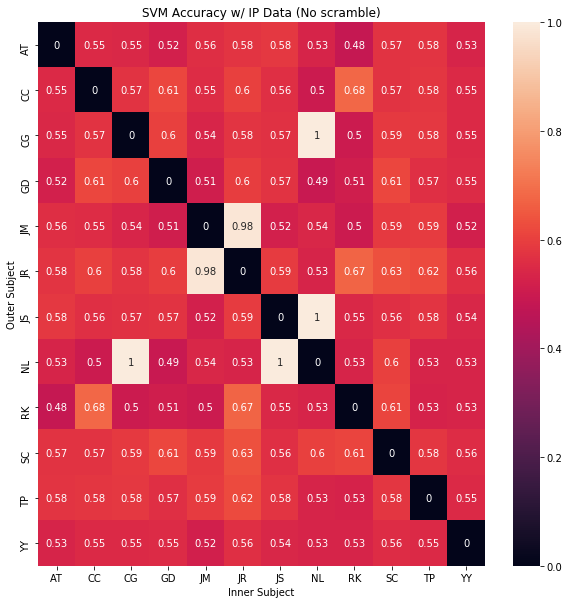

In [383]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(accs_unscrambled.fillna(value=0), annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('SVM Accuracy w/ IP Data (No scramble)')
ax.set_ylabel('Outer Subject')
ax.set_xlabel('Inner Subject')
plt.savefig('acc_heatmap.png')

In [438]:
np.mean(vals)

0.5508935508935509

### 3 Folds

(array([ 8., 12., 42., 34., 16.,  8.,  2.,  0.,  0.,  2.,  0.,  2.,  0.,
         0.,  0.,  0.,  2.,  2.,  0.,  2.]),
 array([0.47727273, 0.50340909, 0.52954545, 0.55568182, 0.58181818,
        0.60795455, 0.63409091, 0.66022727, 0.68636364, 0.7125    ,
        0.73863636, 0.76477273, 0.79090909, 0.81704545, 0.84318182,
        0.86931818, 0.89545455, 0.92159091, 0.94772727, 0.97386364,
        1.        ]),
 <a list of 20 Patch objects>)

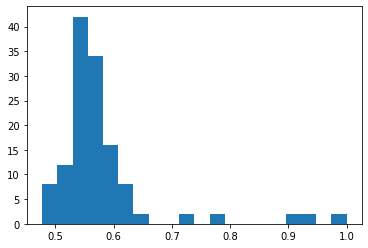

In [409]:
accs_unscrambled = pd.read_csv('output/no_scramble3.csv', sep='\t', index_col=0)
vals = []
for column in accs_unscrambled:
    vals.extend(accs_unscrambled[column].tolist())
vals = [x for x in vals if str(x) != 'nan']

plt.hist(vals, bins=20)

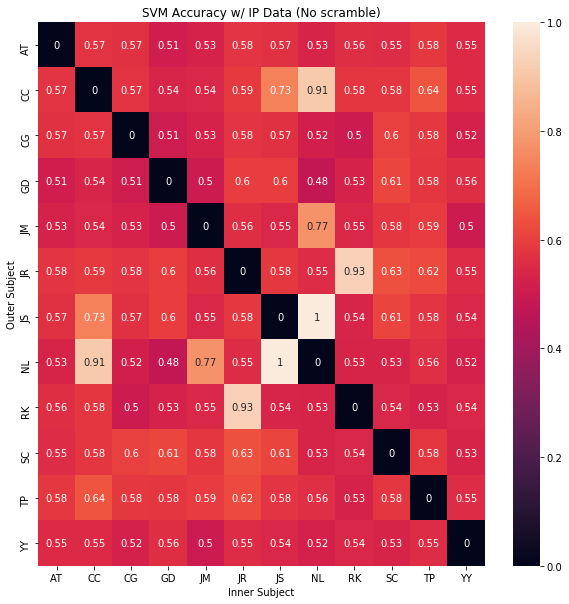

In [401]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(accs_unscrambled.fillna(value=0), annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('SVM Accuracy w/ IP Data (No scramble)')
ax.set_ylabel('Outer Subject')
ax.set_xlabel('Inner Subject')
plt.savefig('acc_heatmap.png')

In [272]:
outer_accs

[0.5546875,
 0.5241935483870968,
 0.5546875,
 0.5606060606060606,
 0.5234375,
 0.5625,
 0.5390625,
 0.5080645161290323,
 0.53125,
 0.532258064516129,
 0.5390625,
 0.5390625]

## Scrambled Labels

In [398]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

gamma_range = {'start': -13, 'stop': 1, 'num': 8, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 8, 'base': 2.0}

accs_scrambled, outer_accs_scrambled = train(path, roi, conds, block_length, gamma_range, C_range, scramble=True)
#accs_scrambled.to_csv('scrambled.csv', sep='\t')

SyntaxError: invalid syntax (<ipython-input-398-da3333acc88c>, line 10)

Text(0.5, 69.0, 'Inner Subject')

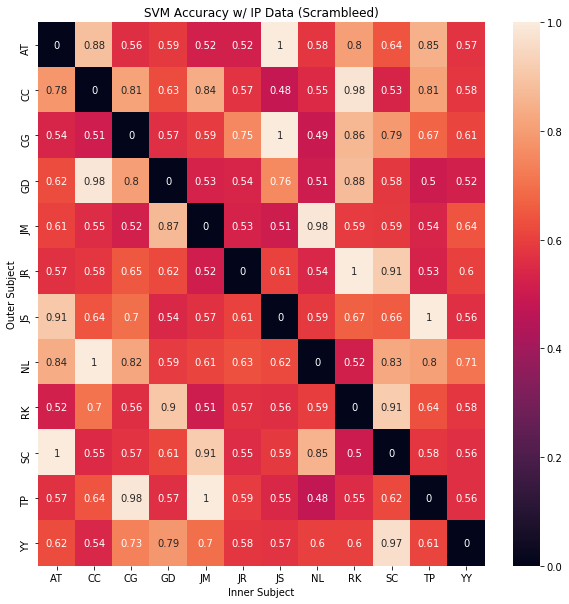

In [350]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(accs_scrambled.fillna(value=0), annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('SVM Accuracy w/ IP Data (Scrambled)')
ax.set_ylabel('Outer Subject')
ax.set_xlabel('Inner Subject')

(array([16., 38., 27.,  9.,  5.,  5.,  9.,  6.,  5., 12.]),
 array([0.4765625 , 0.52890625, 0.58125   , 0.63359375, 0.6859375 ,
        0.73828125, 0.790625  , 0.84296875, 0.8953125 , 0.94765625,
        1.        ]),
 <a list of 10 Patch objects>)

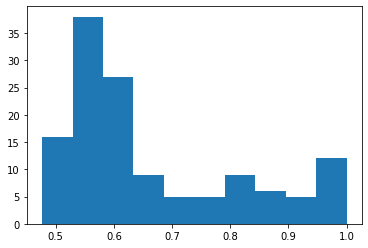

In [374]:
vals = []
for column in accs_scrambled:
    vals.extend(accs_scrambled[column].tolist())
vals = [x for x in vals if str(x) != 'nan']

plt.hist(vals)

### Training with whole dataset

In [416]:
'''
Trains and tests the classifier.

path:          path to data files
roi:           which area of brain imaging to check (0 for V1, 1 for MT)
conds:         which conditional datasets to classify (trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3)
block_length:  standardized number of voxels per block
gamma_range:   dictionary of start, stop, num, and base values to generate gamma values to search grid for
C_range:       dictionary of start, stop, num, and base values to generate C values to search grid for
scramble:      boolean value specifying whether training labels should be scrambled
'''
def train_with_all(path, roi, conds, block_length, gamma_range, C_range, grid_folds=5, scramble=False):
    
    subjects, suffix = get_subjects(path)
    acc_report = pd.DataFrame(index=subjects, columns=subjects)
    outer_accs = []
    
    for outer_subject in range(len(subjects)):
        
        print("Currently on outer subject #%i." % (outer_subject+1))

        dummy_subject = 0
        if outer_subject == 0:
            dummy_subject = 1
        _, _, _, _, x_test_outer, y_test_outer = generate_data(subjects, dummy_subject, outer_subject, path, suffix, block_length, roi, conds)
        
        best_params = None
        best_acc = None
        start_time = time.time()
        
        for inner_subject in range(len(subjects)):

            if inner_subject == outer_subject:
                continue

            print("Currently on inner subject #%i." % (inner_subject+1))    
            x_train, y_train, x_test1, y_test1, x_test2, y_test2 = generate_data(subjects, inner_subject, outer_subject, path, suffix, block_length, roi, conds)
            
            x_whole = np.vstack((x_train, x_test1, x_test2))
            y_whole = np.concatenate((y_train, y_test1, y_test2))

            if scramble:
                scramble_labels(y_train, classes)
                
            params = get_optimal_params(x_whole, y_whole, gamma_range, C_range, grid_folds)    
            
            # train model
            svclassifier = SVC(kernel=params['kernel'], gamma=params['gamma'], C=params['C'], max_iter=-1)
            #svclassifier = SVC(kernel=kernel_type, gamma='auto')
            svclassifier.fit(x_whole, y_whole)
            
            acc = svclassifier.score(x_whole, y_whole)
            if best_params == None or acc > best_acc:
                best_params = params
                best_acc = acc
            
            index = subjects[outer_subject]
            col = subjects[inner_subject]
            acc_report.at[index, col] = acc

        print('Testing outer subject...')
        svclassifier = SVC(kernel=best_params['kernel'], gamma=best_params['gamma'], C=best_params['C'], max_iter=-1)
        svclassifier.fit(x_test_outer, y_test_outer)
        
        outer_acc = svclassifier.score(x_test_outer, y_test_outer)
        outer_accs.append(outer_acc)
        clear_output()
        
        end_time = time.time()
        exec_time = end_time - start_time
        minutes = exec_time // 60
        seconds = exec_time % 60
        print('Last turn took %i minutes and %f seconds.' % (minutes, seconds))
    
    clear_output()
    return acc_report, outer_accs

In [418]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

gamma_range = {'start': -13, 'stop': 1, 'num': 8, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 8, 'base': 2.0}

accs_all, outer_accs_all = train_with_all(path, roi, conds, block_length, gamma_range, C_range)
accs_all.to_csv('no_scramble_all.csv', sep='\t')

Currently on outer subject #1.
Currently on inner subject #2.
Currently on inner subject #3.
Currently on inner subject #4.
Currently on inner subject #5.
Currently on inner subject #6.
Currently on inner subject #7.
Currently on inner subject #8.
Currently on inner subject #9.
Currently on inner subject #10.
Currently on inner subject #11.
Currently on inner subject #12.
Testing outer subject...
Last turn took 27 minutes and 30.866486 seconds.
Currently on outer subject #2.
Currently on inner subject #1.
Currently on inner subject #3.
Currently on inner subject #4.
Currently on inner subject #5.
Currently on inner subject #6.
Currently on inner subject #7.
Currently on inner subject #8.
Currently on inner subject #9.
Currently on inner subject #10.
Currently on inner subject #11.
Currently on inner subject #12.
Testing outer subject...
Last turn took 28 minutes and 51.689570 seconds.
Currently on outer subject #3.
Currently on inner subject #1.
Currently on inner subject #2.
Currently

(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  4.,  7., 13., 11.,
        27., 29., 12.,  8.,  5.,  6.,  6.]),
 array([0.44871795, 0.45608974, 0.46346154, 0.47083333, 0.47820513,
        0.48557692, 0.49294872, 0.50032051, 0.50769231, 0.5150641 ,
        0.5224359 , 0.52980769, 0.53717949, 0.54455128, 0.55192308,
        0.55929487, 0.56666667, 0.57403846, 0.58141026, 0.58878205,
        0.59615385]),
 <a list of 20 Patch objects>)

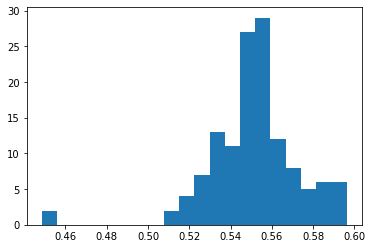

In [419]:
vals = []
for column in accs_all:
    vals.extend(accs_all[column].tolist())
vals = [x for x in vals if str(x) != 'nan']

plt.hist(vals, bins=20)

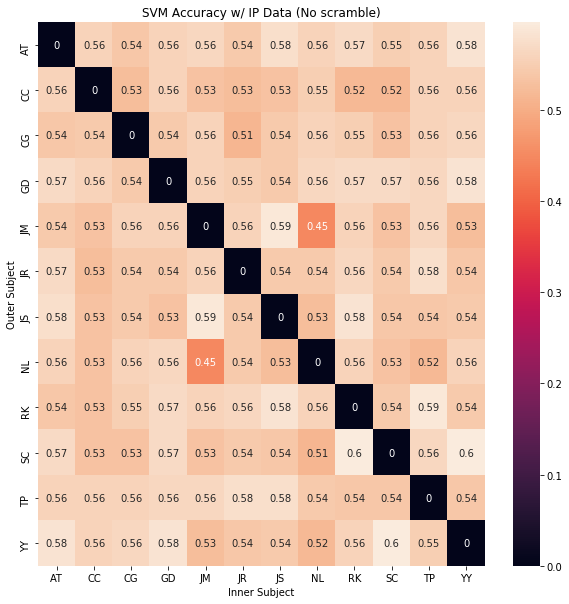

In [420]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(accs_all.fillna(value=0), annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('SVM Accuracy w/ IP Data (No scramble)')
ax.set_ylabel('Outer Subject')
ax.set_xlabel('Inner Subject')
plt.savefig('acc_heatmap.png')

In [434]:
x1, y1, x2, y2, x3, y3 = generate_data(subjects, 0, 1, path, suffix, block_length, roi, conds)
x_whole = np.vstack((x1, x2, x3))
y_whole = np.concatenate((y1, y2, y3))

params = get_optimal_params(x_whole, y_whole, gamma_range, C_range, folds=5) 
svclassifier = SVC(kernel=params['kernel'], gamma=params['gamma'], C=params['C'], max_iter=-1)
svclassifier.fit(x_whole, y_whole)

SVC(C=68.16262972415761, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0005538635362282531,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [435]:
outer_accs_all = {}
for subject in subjects:
    test_data = extract_subject_data(path, subject, suffix, roi, conds, block_length)
    x_test, y_test = test_data['x'], test_data['y']
    outer_accs_all.update({subject: svclassifier.score(x_test, y_test)})

In [436]:
outer_accs_all

{'AT': 0.5,
 'CC': 0.5,
 'CG': 0.5,
 'GD': 0.5,
 'JM': 0.5,
 'JR': 0.5,
 'JS': 0.5,
 'NL': 0.5,
 'RK': 0.5,
 'SC': 0.5,
 'TP': 0.5,
 'YY': 0.5}

## Histograms of Different Kernel Accuracies

Note: This is without parameter grid search

Currently testing linear kernel.
Currently testing rbf kernel.
Currently testing poly kernel.
Currently testing sigmoid kernel.


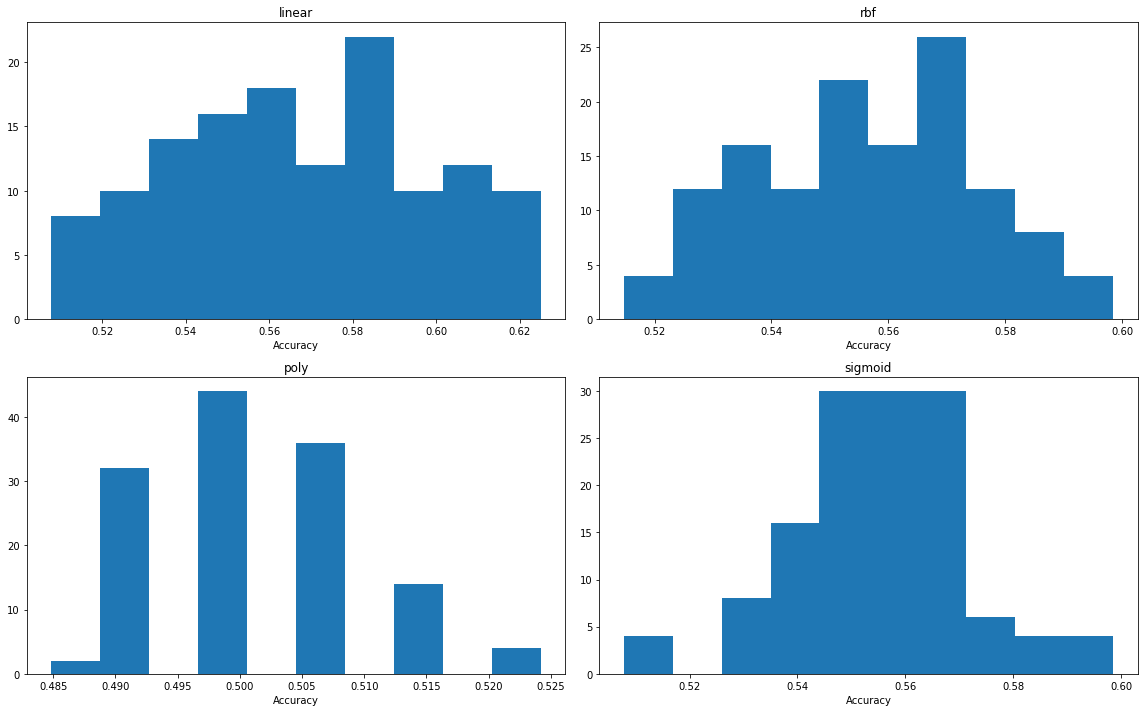

In [250]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624 

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
fig, axes = plt.subplots(2, 2, figsize=(16,10), squeeze=False)

kernel_accs = {}

for i, kernel in enumerate(kernels):
    
    print("Currently testing %s kernel." % (kernel))
    accs, outer_accs = train(path, kernel, roi, conds, block_length)
    kernel_accs[kernel] = accs
    vals = []
    for column in accs:
        vals.extend(accs[column].tolist())
    vals = [x for x in vals if str(x) != 'nan']
    
    row = 0
    if i > 1:
        row = 1
    col = 0
    if i == 1 or i == 3:
        col = 1
    
    axes[row, col].hist(vals)
    axes[row, col].set_title(kernel)
    axes[row, col].set_xlabel('Accuracy')

fig.tight_layout()
plt.savefig('acc_comparison.png')
plt.show()

### Debugging/Testing

In [345]:
C_range = {'start': -3, 'stop': 11, 'num': 8, 'base': 2.0}
gamma_range = {'start': -13, 'stop': 1, 'num': 8, 'base': 2.0}

start_time = time.time()
x_train, y_train, x_test, y_test, _, _ = generate_data(subjects, 1, 0, path, suffix, block_length, roi, conds)

opt_params = get_optimal_params(x_train, y_train, gamma_range, C_range)

end_time = time.time()
exec_time = end_time - start_time
minutes = exec_time // 60
seconds = exec_time % 60
print('Operation took %i minutes and %f seconds.' % (minutes, seconds))

{'C': 8.0, 'gamma': 0.001953125, 'kernel': 'sigmoid'}
{'C': 6.964404506368992, 'gamma': 0.0029603839189656206, 'kernel': 'sigmoid'}
Operation took 1 minutes and 29.594329 seconds.


In [322]:
C_range = np.logspace(start=-3, stop=7, num=6, base=2.0)
gamma_range = np.logspace(start=-9, stop=1, num=6, base=2.0)
tuned_params = [{'kernel': ['linear', 'rbf', 'sigmoid'], 'gamma': gamma_range, 'C': C_range}]

start_time = time.time()
x_train, y_train, x_test, y_test, _, _ = generate_data(subjects, 1, 0, path, suffix, block_length, roi, conds)
clf = GridSearchCV(SVC(), tuned_params, cv=5)
clf.fit(x_train, y_train)

end_time = time.time()
exec_time = end_time - start_time
minutes = exec_time // 60
seconds = exec_time % 60
print('Operation took %i minutes and %f seconds.' % (minutes, seconds))

clf.best_params_

KeyboardInterrupt: 

In [11]:
kernel_type = 'poly'
path = r'scans/output/PRE/'
suffix = "PRE_EVERY_TR_roi.mat"
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
subjects = get_subjects(path)
block_length = 624                 # minimum block length

inner_subject = 3
outer_subject = 0
x_train, y_train, x_test, y_test = generate_data(subjects, inner_subject, outer_subject, path, suffix, block_length, roi, conds)
svclassifier = SVC(kernel=kernel_type, gamma='auto', max_iter=-1)
svclassifier.fit(x_train, y_train)

svclassifier.score(x_test, y_test)


0.5

In [837]:
kernel_type = 'sigmoid'
path = r'scans/output/PRE/'
suffix = "PRE_EVERY_TR_roi.mat"
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
subjects = get_subjects(path)
block_length = 624                 # minimum block length

data = extract_subject_data(path, subjects[2], suffix, roi, conds, block_length)
#svclassifier = SVC(kernel=kernel_type, gamma='auto', max_iter=-1)
#svclassifier.fit(data['x'], data['y'])

In [53]:
classes = ['trained_ip', 'untrained_ip']

data = extract_subject_data(path, subjects[0], suffix, roi, conds, block_length)
scramble_labels(data['y'], classes)

0: trained_ip -> untrained_ip
5: trained_ip -> untrained_ip
6: untrained_ip -> trained_ip
8: trained_ip -> untrained_ip
7: untrained_ip -> trained_ip
1: trained_ip -> untrained_ip
